In [1]:
import osmnx as ox, geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from libpysal import weights
import momepy
import pickle

# Data cleaning

In [2]:
# Create a graph from an address with a specific distance around it
G4 = ox.graph_from_address(
    address="Churchillplein 10, 2517 KK, Den Haag",
    dist=2000, # 2000 meters from the address
    dist_type="network", # Following streets
    network_type="drive", # Only drivable roads
    
)

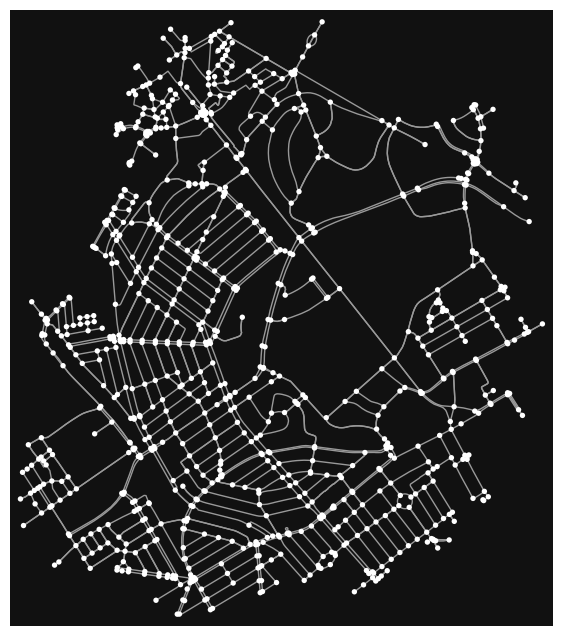

In [3]:
# Project the graph to the UTM zone appropriate for its geographic location
G4_projected = ox.project_graph(G4)
# Plot the projected graph
fig, ax = ox.plot_graph(G4_projected)

In [4]:
type(G4)

networkx.classes.multidigraph.MultiDiGraph

In [5]:
# This has cleaner data, thus probably more likely to be right.
G4 = ox.add_edge_speeds(G4)

In [6]:
# Adds travel times
G4 = ox.add_edge_travel_times(G4)

In [7]:
# Convert the graph to GeoDataFrames
nodes, edges = momepy.nx_to_gdf(G4, points=True, lines=True)

C:\Users\mnmar\AppData\Local\Temp\ipykernel_28416\2038614436.py:2: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes, edges = momepy.nx_to_gdf(G4, points=True, lines=True)


In [8]:
display(nodes.head())

,y,x,street_count,nodeID,highway,geometry
0,52.105760,4.280459,3,0,NaN,POINT (4.28046 52.10576)
1,52.106239,4.279667,3,1,NaN,POINT (4.27967 52.10624)
2,52.092830,4.288591,3,2,NaN,POINT (4.28859 52.09283)
3,52.091743,4.284993,2,3,NaN,POINT (4.28499 52.09174)
4,52.076931,4.275932,4,4,NaN,POINT (4.27593 52.07693)


In [9]:
display(edges.head())

,osmid,name,highway,maxspeed,oneway,reversed,length,speed_kph,travel_time,geometry,lanes,ref,bridge,width,junction,access,tunnel,node_start,node_end
0,4478977,Marcelisstraat,residential,30,False,False,75.920,30.0,9.1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1,208063030,Stuurmanstraat,residential,30,False,False,46.188,30.0,5.5,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,428
2,208063030,Stuurmanstraat,residential,30,False,True,21.749,30.0,2.6,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,423
3,4478977,Marcelisstraat,residential,30,False,True,75.920,30.0,9.1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
4,7495779,Marcelisstraat,residential,30,True,False,32.299,30.0,3.9,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,430


# Check for column data types, NaN values and duplicates

In [10]:
# Check data types of nodes DataFrame
print(nodes.dtypes)

# Check data types of edges DataFrame
print(edges.dtypes)

y                float64
x                float64
street_count       int64
nodeID             int64
highway           object
geometry        geometry
dtype: object
osmid            object
name             object
highway          object
maxspeed         object
oneway             bool
reversed         object
length          float64
speed_kph       float64
travel_time     float64
geometry       geometry
lanes            object
ref              object
bridge           object
width            object
junction         object
access           object
tunnel           object
node_start        int64
node_end          int64
dtype: object


Maxspeed, width and lanes should be checked if they are consistently numeric.

In [11]:
edges['maxspeed']

0       30
1       30
2       30
3       30
4       30
        ..
1822    30
1823    30
1824    30
1825    50
1826    30
Name: maxspeed, Length: 1827, dtype: object

In [12]:
edges['speed_kph']

0       30.0
1       30.0
2       30.0
3       30.0
4       30.0
        ... 
1822    30.0
1823    30.0
1824    30.0
1825    50.0
1826    30.0
Name: speed_kph, Length: 1827, dtype: float64

We can see that there are lists sometimes, so they should be solved

In [13]:
def handle_maxspeed(value):
    if isinstance(value, list):
        return value[0]  # to take the smallest value
    return value

edges['maxspeed'] = edges['maxspeed'].apply(handle_maxspeed).astype(float)

In [14]:
edges['maxspeed'].unique()

array([30., 50., nan, 15.])

In [15]:
edges['width'].unique

<bound method Series.unique of 0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
1822    NaN
1823    NaN
1824    NaN
1825    NaN
1826    NaN
Name: width, Length: 1827, dtype: object>

The width column only has NaN values, so this column will be dropped

In [16]:
edges = edges.drop(columns=['width'])

In [17]:
edges['lanes']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
1822    NaN
1823    NaN
1824    NaN
1825      1
1826    NaN
Name: lanes, Length: 1827, dtype: object

The NaN values in the lanes column will be filled up with 2

In [18]:
def handle_lanes(value):
    if isinstance(value, list):
        return value[0]  # Take the first element of the list
    return value

# Apply the function to handle lists and then fill NaN values with 2
edges['lanes'] = edges['lanes'].apply(handle_lanes).fillna(2).astype(int)

Reversed column will be taken out because it is not necessary

In [19]:
edges = edges.drop(columns=['reversed'])

In [20]:
# Check for NaN values in nodes DataFrame
print(nodes.isna().sum())

y                 0
x                 0
street_count      0
nodeID            0
highway         860
geometry          0
dtype: int64


The highway column only has 3 non NaN values, so the whole column will be dropped

In [21]:
nodes = nodes.drop(columns=['highway'])

In [22]:
# Check for NaN values in edges DataFrame
print(edges.isna().sum())

osmid             0
name             35
highway           0
maxspeed         15
oneway            0
length            0
speed_kph         0
travel_time       0
geometry        607
lanes             0
ref            1699
bridge         1800
junction       1792
access         1821
tunnel         1824
node_start        0
node_end          0
dtype: int64


In [23]:
# Fill the NaN values in the name column with Unnamed so we can still use it in the analysis
edges['name'] = edges['name'].fillna('Unnamed')

In [24]:
# Filling with the average speed
edges['maxspeed'] = edges['maxspeed'].fillna(edges['maxspeed'].mean())

In [25]:
# Fill the bridge column NaN values with 0
edges['bridge'] = edges['bridge'].fillna('no')

The columns ref, junction, access and tunnel will be taken out

In [26]:
# Drop the specified columns
edges = edges.drop(columns=['ref', 'junction', 'access', 'tunnel'])

# Check the result
print(edges.isna().sum())

osmid            0
name             0
highway          0
maxspeed         0
oneway           0
length           0
speed_kph        0
travel_time      0
geometry       607
lanes            0
bridge           0
node_start       0
node_end         0
dtype: int64


Although the geometry column still has a lot of NaN values, the column is too critical to delete them. This is why they will be kept

In [27]:
# Drop all the rows that have busway value in the highway column
edges = edges[~edges['highway'].str.contains('busway', case=False, na=False)]

In [28]:
# Check for any duplicates in the whole DataFrame
duplicate_nodes_all = nodes[nodes.duplicated()]

print(f"Duplicate nodes in the entire DataFrame:\n{duplicate_nodes_all}")

Duplicate nodes in the entire DataFrame:
Empty GeoDataFrame
Columns: [y, x, street_count, nodeID, geometry]
Index: []


In [29]:
# Iterate through each column to check for lists
for column in edges.columns:
    # Check if any rows contain a list in the column
    rows_with_lists = edges[edges[column].apply(lambda x: isinstance(x, list))]
    if not rows_with_lists.empty:
        print(f"Column '{column}' contains lists in the following rows:")
        print(rows_with_lists[[column]])

Column 'osmid' contains lists in the following rows:
                                     osmid
6                  [1346438008, 352990278]
9         [7493808, 308873075, 1346438006]
31                      [7493624, 7493575]
34                 [1110574872, 143486668]
40                    [447835093, 7494525]
...                                    ...
1788              [1246826945, 1180958779]
1813                 [1317703931, 7495543]
1818  [1344871904, 1344875938, 1344878861]
1822           [7495648, 7495507, 7495638]
1824              [1344873769, 1344878862]

[302 rows x 1 columns]
Column 'name' contains lists in the following rows:
                                                 name
170                       [Reinkenstraat, Conradkade]
223                       [Reinkenstraat, Conradkade]
263                           [Beeklaan, Houtrustweg]
273                 [Piet Heinstraat, Piet Heinplein]
333                   [2e Schuytstraat, Lübeckstraat]
375                   [2e Schuy

The edges dataframe still contains some lists in rows, however these will not affect the analysis so they will be kept untouched.

# NetworkX

In [30]:
# Create a new column 'Closed' and set it to False by default
edges['Closed'] = False

# Update the column to True where the name is either 'Eisenhowerlaan' or 'Johan de Wittlaan'
# Eisenhowerlaan will be used as a bike lane only and the Johan de Wittlaan will be closed due to construction
edges.loc[edges['name'].isin(['Eisenhowerlaan', 'Johan de Wittlaan']), 'Closed'] = True

In [31]:
import shapely.geometry as geom

# Create an empty graph
G6 = nx.DiGraph()

# Add nodes with attributes from nodes
for _, row in nodes.iterrows():
    G6.add_node(row['nodeID'], 
               x=row['x'], 
               y=row['y'], 
               street_count=row['street_count'],  
               geometry=row['geometry'])  # Geometry is a shapely Point

# Add edges with attributes from edges
for _, row in edges.iterrows():
    G6.add_edge(row['node_start'], row['node_end'], 
                osmid=row['osmid'], 
                name=row['name'], 
                highway=row['highway'], 
                maxspeed=row['maxspeed'], 
                max_kph=row["speed_kph"],
                travel_time=row["travel_time"],
                oneway=row['oneway'], 
                length=row['length'], 
                lanes=row['lanes'], 
                geometry=row['geometry'],  # Geometry is a shapely LineString
                bridge=row['bridge'], 
                Closed=row['Closed'])  

In [32]:
# Create a position dictionary for nodes
pos = {node: (data['x'], data['y']) for node, data in G6.nodes(data=True)}

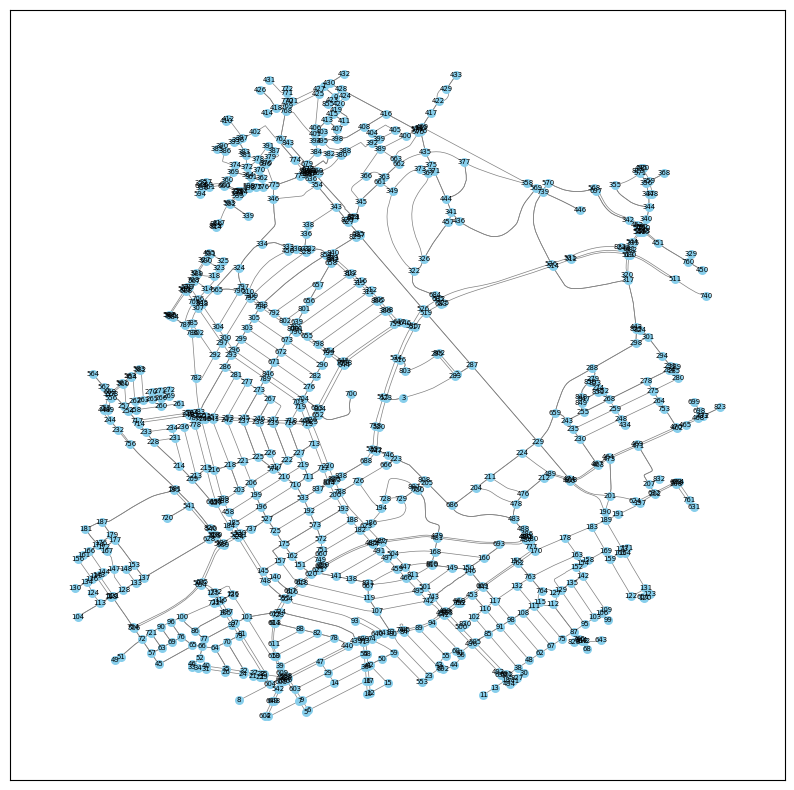

In [33]:
from matplotlib.collections import LineCollection

# Prepare edge geometries
edge_lines = []
for u, v, data in G6.edges(data=True):
    if 'geometry' in data and data['geometry']:  
        edge_lines.append(list(data['geometry'].coords))
    else:
        # Fallback to straight line between nodes
        edge_lines.append([pos[u], pos[v]])

# Create LineCollection for edges
lc = LineCollection(edge_lines, colors='gray', linewidths=0.5)

# Plot the graph
fig, ax = plt.subplots(figsize=(10, 10))
ax.add_collection(lc)

# Draw the nodes
nx.draw_networkx_nodes(G6, pos, ax=ax, node_size=30, node_color='skyblue')

# Optionally add labels
nx.draw_networkx_labels(G6, pos, ax=ax, font_size=5)

# Adjust plot limits and display the figure
ax.autoscale()
ax.margins(0.1)
plt.show()

In [34]:
# Check nodes with no connections (degree 0)
isolated_nodes = [node for node in G6.nodes if G6.degree(node) == 0]

if isolated_nodes:
    print("Nodes with no connections:")
    for node in isolated_nodes:
        print(node)

# Check edges with no valid connections
for u, v, data in G6.edges(data=True):
    if G6.degree(u) == 0 or G6.degree(v) == 0:
        print(f"Edge between {u} and {v} has no valid connections.")


Nodes with no connections:
766


Node 680 has no connections so that node will be dropped

In [35]:
# Remove node 766 from the graph
if isolated_nodes:
    G6.remove_node(isolated_nodes[0])

    # Drop node 766 from the dataframe
    nodes = nodes[nodes['nodeID'] != isolated_nodes[0]]

Create a dataframe for cars and add car_id, start and end node, travel time and current edge. 

In [36]:
import random

# Create the DataFrame for cars (100 cars)
cars = pd.DataFrame({
    'car_id': range(1, 101),  # 100 cars
    'start_node': random.choices(list(G6.nodes), k=100),
    'end_node': random.choices(list(G6.nodes), k=100),
    'total_travel_time': 0,
    'current_edge': None,  # Initially, cars are not on any edge
    'path_log': [[] for _ in range(100)],  # Initialize empty path_log
    'nodes_visited': [[] for _ in range(100)],  # Initialize empty nodes_visited
    'edges_visited': [[] for _ in range(100)],  # Initialize empty edges_visited
    'total_delay': 0
})
display(cars.head())


,car_id,start_node,end_node,total_travel_time,current_edge,path_log,nodes_visited,edges_visited,total_delay
0,1,849,714,0,None,[],[],[],0
1,2,192,636,0,None,[],[],[],0
2,3,821,696,0,None,[],[],[],0
3,4,121,808,0,None,[],[],[],0
4,5,694,119,0,None,[],[],[],0


Add edge weights for capacity of the roads and delay column

In [37]:
# Add capacity and delay columns to edges
for u, v, data in G6.edges(data=True):
    length = data.get('length', 1)  
    lanes = data.get('lanes', 1)
    delay = data.get('delay',0)
    maxspeed = data.get('maxspeed', 30) # Default maxspeed if not present
    data['capacity'] = length * lanes * 0.1  # Capacity factor
    data['current_cars'] = 0  # Initially, no cars on the edge
    # Convert maxspeed from km/h to m/s
    maxspeed_m_per_s = maxspeed * (5 / 18)
    # Calculate travel time (time = distance / speed)
    if maxspeed_m_per_s > 0:
        travel_time = length / maxspeed_m_per_s
    else:
        travel_time = float('inf')  # Avoid division by zero if maxspeed is 0
    
    # Combined weight: travel time + delay
    data['combined_weight'] = travel_time + delay

In [38]:
# Check the attributes of a few edges
for u, v, data in list(G6.edges(data=True))[:5]:  # Inspect the first 5 edges
    print(f"Edge ({u}, {v}):")
    print(f"  Length: {data.get('length', 'N/A')}")
    print(f"  Lanes: {data.get('lanes', 'N/A')}")
    print(f"  Capacity: {data.get('capacity', 'N/A')}")
    print(f"  Current Cars: {data.get('current_cars', 'N/A')}")
    print(f"  Delay: {data.get('delay', 'N/A')}")
    print()

Edge (0, 1):
  Length: 75.92
  Lanes: 2
  Capacity: 15.184000000000001
  Current Cars: 0
  Delay: N/A

Edge (0, 428):
  Length: 46.188
  Lanes: 2
  Capacity: 9.2376
  Current Cars: 0
  Delay: N/A

Edge (0, 423):
  Length: 21.749
  Lanes: 2
  Capacity: 4.3498
  Current Cars: 0
  Delay: N/A

Edge (1, 0):
  Length: 75.92
  Lanes: 2
  Capacity: 15.184000000000001
  Current Cars: 0
  Delay: N/A

Edge (1, 430):
  Length: 32.299
  Lanes: 2
  Capacity: 6.4598
  Current Cars: 0
  Delay: N/A



Add delay column to the nodes

In [39]:
# Add delay column to nodes
for node in G6.nodes:
    G6.nodes[node]['current_cars'] = 0  # Count of cars on the node
    G6.nodes[node]['delay'] = 0  # Default delay

# Base scenario

In [40]:
# Add paths to the cars 
for idx, car in cars.iterrows():
    start_node = car['start_node']
    end_node = car['end_node']
    try:
        # Calculate the shortest path for each car and store it in path_log
        path = nx.shortest_path(G6, start_node, end_node, weight='combined_weight')
        cars.at[idx, 'path_log'] = path
        cars.at[idx, 'nodes_visited'] = path  # Store the nodes visited in order
    except nx.NetworkXNoPath:
        print(f"No path found for car {car['car_id']}")

No path found for car 16
No path found for car 29
No path found for car 31
No path found for car 49
No path found for car 66


In [41]:
# Check the first few cars and their paths
for idx, car in cars.head().iterrows():
    print(f"Car {car['car_id']} path: {car['path_log']}")
    start_node = car['start_node']
    end_node = car['end_node']
    # Calculate the combined weight for the path
    total_weight = sum(G6.edges[u, v]['combined_weight'] for u, v in zip(car['path_log'], car['path_log'][1:]))
    print(f"Total combined weight for car {car['car_id']}: {total_weight}")


Car 1 path: [849, 848, 850, 279, 288, 229, 224, 211, 204, 686, 205, 808, 223, 746, 522, 529, 688, 838, 836, 833, 837, 533, 710, 210, 574, 225, 237, 245, 253, 252, 251, 250, 783, 784, 256, 717, 714]
Total combined weight for car 1: 257.590488
Car 2 path: [192, 533, 837, 834, 835, 836, 220, 625, 626, 704, 846, 671, 672, 673, 800, 702, 639, 801, 656, 657, 658, 842, 841, 840, 829, 337, 635, 627, 820, 343, 354, 636]
Total combined weight for car 2: 151.80537600000002
Car 3 path: [821, 819, 820, 343, 354, 636, 857, 856, 861, 678, 677, 859, 701, 773, 775, 776, 675, 599, 361, 370, 696]
Total combined weight for car 3: 66.123264
Car 4 path: [121, 128, 133, 137, 628, 629, 508, 509, 524, 521, 737, 527, 533, 837, 834, 835, 838, 688, 747, 746, 223, 808]
Total combined weight for car 4: 125.91036
Car 5 path: [694, 125, 114, 105, 92, 97, 101, 615, 723, 724, 554, 616, 618, 119]
Total combined weight for car 5: 108.88264799999999


In [42]:
# Function to simulate car movement over timesteps and update delay and travel time
def move_cars_over_time(cars, max_timesteps=100):
    for t in range(max_timesteps):  # Iterate through time steps
        for idx, car in cars.iterrows():
            # Ensure the car has a valid path to move along
            if len(car['path_log']) > 1:  # There should be more than 1 node to move
                current_node = car['path_log'][0]  # Get the current node
                next_node = car['path_log'][1]  # Get the next node in the path
                
                # Calculate delay at the current node (if more than 1 car at the node)
                if G6.nodes[current_node]['current_cars'] > 1:
                    car['total_delay'] += 3  # Add 3 minutes delay for congestion at node
                    
                # Update total travel time as the car moves to the next node
                edge_data = G6.get_edge_data(current_node, next_node)
                edge_length = edge_data.get('length', 1)
                edge_delay = 0
                # Add delay on the edge if too many cars are on it
                if edge_data['current_cars'] > 3:
                    edge_delay = 5  # Add 5 minutes delay on the edge
                car['total_travel_time'] += edge_length + edge_delay  # Update travel time
                
                # Move car to the next node in its path
                car['path_log'] = car['path_log'][1:]  # Remove the current node from the path
                G6.nodes[current_node]['current_cars'] -= 1  # Decrease the current car count at the node
                G6.nodes[next_node]['current_cars'] += 1  # Increase the current car count at the next node
                G6.edges[current_node, next_node]['current_cars'] += 1  # Update car count on the edge
                
                # Add the node to nodes_visited (ensure uniqueness)
                if next_node not in car['nodes_visited']:
                    car['nodes_visited'].append(next_node)

                # Add the edge to edges_visited (ensure uniqueness)
                edge = tuple(sorted([current_node, next_node]))  # Use sorted to avoid direction differences
                if edge not in car['edges_visited']:
                    car['edges_visited'].append(edge)

            else:
                # If the car has finished its path, do not modify path_log or travel times anymore
                if len(car['path_log']) == 1:  # Car reached destination
                    # Do not modify path_log anymore
                    continue

            # Ensure that changes are reflected in the dataframe
            cars.at[idx, 'total_travel_time'] = car['total_travel_time']
            cars.at[idx, 'total_delay'] = car['total_delay']
            cars.at[idx, 'path_log'] = car['path_log']

        # Debugging: Print progress every 10 timesteps
        if t % 10 == 0:
            print(f"Step {t}:")
            print(cars[['car_id', 'total_travel_time', 'total_delay', 'path_log']].head())
    
    return cars

In [43]:
# Finalizing results: Ensure start_node is added to the start and end_node to the end of nodes_visited
def finalize_results(cars):
    for idx, car in cars.iterrows():
        # Ensure start_node is at the beginning and end_node is at the end of nodes_visited
        if car['start_node'] not in car['nodes_visited']:
            car['nodes_visited'].insert(0, car['start_node'])  # Add start_node at the beginning
        if car['end_node'] not in car['nodes_visited']:
            car['nodes_visited'].append(car['end_node'])  # Add end_node at the end

    return cars

In [44]:
# Create a DataFrame with unique nodes and edges visited
def create_final_dataframe(cars):
    final_results = pd.DataFrame({
        'car_id': cars['car_id'],
        'start_node': cars['start_node'],
        'end_node': cars['end_node'],
        'total_travel_time': cars['total_travel_time'],
        'total_delay': cars['total_delay'],
        'nodes_visited': [list(set(nodes)) for nodes in cars['nodes_visited']],  # Remove duplicates
        'edges_visited': [list(set(edges)) for edges in cars['edges_visited']]  # Remove duplicates
    })
    
    # Sort the columns (optional for easier inspection)
    final_results = final_results[['car_id', 'start_node', 'end_node', 'total_travel_time', 'total_delay', 'nodes_visited', 'edges_visited']]
    
    return final_results


In [45]:
# Run the simulation
cars = move_cars_over_time(cars, max_timesteps=100)

# Finalize the results (add start_node and end_node)
cars = finalize_results(cars)

# Create the final results DataFrame
final_results = create_final_dataframe(cars)

# Show the final results
display(final_results.head())

Step 0:
   car_id  total_travel_time  total_delay  \
0       1             30.457            0   
1       2             71.629            0   
2       3              7.677            0   
3       4             55.649            0   
4       5             70.438            0   

                                            path_log  
0  [848, 850, 279, 288, 229, 224, 211, 204, 686, ...  
1  [533, 837, 834, 835, 836, 220, 625, 626, 704, ...  
2  [819, 820, 343, 354, 636, 857, 856, 861, 678, ...  
3  [128, 133, 137, 628, 629, 508, 509, 524, 521, ...  
4  [125, 114, 105, 92, 97, 101, 615, 723, 724, 55...  
Step 10:
   car_id  total_travel_time  total_delay  \
0       1           1376.366            3   
1       2            959.866            0   
2       3            396.353            6   
3       4            874.595           12   
4       5            614.262            3   

                                            path_log  
0  [808, 223, 746, 522, 529, 688, 838, 836, 833, ...  
1

,car_id,start_node,end_node,total_travel_time,total_delay,nodes_visited,edges_visited
0,1,849,714,3170.815,21,"[256, 522, 783, 784, 529, 533, 279, 288, 808, ...","[(224, 229), (783, 784), (522, 746), (836, 838..."
1,2,192,636,2133.408,9,"[656, 657, 658, 533, 671, 672, 673, 800, 801, ...","[(343, 354), (834, 835), (627, 820), (656, 801..."
2,3,821,696,823.596,6,"[773, 775, 776, 675, 677, 678, 819, 820, 821, ...","[(343, 354), (677, 678), (343, 820), (775, 776..."
3,4,121,808,1763.755,36,"[128, 133, 137, 521, 524, 527, 533, 808, 688, ...","[(508, 509), (128, 133), (834, 835), (628, 629..."
4,5,694,119,993.403,3,"[97, 101, 615, 616, 105, 554, 618, 114, 723, 7...","[(92, 97), (101, 615), (97, 101), (554, 724), ..."


In [46]:
from openpyxl import Workbook
from openpyxl.styles import PatternFill

# Save the final results to an Excel file with formatting
with pd.ExcelWriter('simulation_results.xlsx', engine='openpyxl') as writer:
    final_results.to_excel(writer, index=False, sheet_name='Results')
    workbook = writer.book
    worksheet = writer.sheets['Results']
    
    # Define a red fill style
    red_fill = PatternFill(start_color='FF0000', end_color='FF0000', fill_type='solid')
    
    # Column index for 'edges_visited' (0-based in pandas, convert to 1-based for openpyxl)
    edges_visited_col_index = final_results.columns.get_loc('edges_visited') + 1
    
    # Check 'edges_visited' column for empty lists and apply the red fill
    for row in range(2, len(final_results) + 2):  
        edges_visited = final_results.iloc[row - 2]['edges_visited']  # Access the 'edges_visited' column
        if not edges_visited:  # Check if it's an empty list
            for col in range(1, len(final_results.columns) + 1):  # Apply red fill across all columns in the row
                worksheet.cell(row=row, column=col).fill = red_fill

print("Simulation results saved to 'simulation_results.xlsx'")

Simulation results saved to 'simulation_results.xlsx'


# Dit gedeelte hieronder kan denk ik weg

Components 1 to 30 and 32 are possibly islands, so we need to take a closer look at them to make sure cars can actually leave or if they get stuck 

# Vanaf hier wel weer runnen

In [47]:
# Set the CRS for the graph
G6.graph['crs'] = 'EPSG:4326'

In [48]:
import contextily as ctx
from matplotlib.collections import LineCollection

def plot_car_paths(G, cars, car_ids, output_filenames):
    pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

    # Loop over each car
    for car_id, output_filename in zip(car_ids, output_filenames):
        car = cars[cars['car_id'] == car_id].iloc[0]
        nodes_visited = car['nodes_visited']
        edges_visited = car['edges_visited']

        # Prepare edge geometries for the whole graph
        edge_lines = []
        for u, v, data in G.edges(data=True):
            if 'geometry' in data and data['geometry'] is not None:
                edge_lines.append(list(data['geometry'].coords))
            else:
                edge_lines.append([pos[u], pos[v]])

        # Create LineCollection for edges (base graph)
        lc = LineCollection(edge_lines, colors='red', linewidths=0.5)

        # Prepare the edges visited by the car
        car_edges = [(u, v) for u, v in G.edges if (u, v) in edges_visited or (v, u) in edges_visited]
        car_edge_lines = []
        for u, v in car_edges:
            if 'geometry' in G.edges[u, v] and G.edges[u, v]['geometry'] is not None:
                car_edge_lines.append(list(G.edges[u, v]['geometry'].coords))
            else:
                car_edge_lines.append([pos[u], pos[v]])

        # Create LineCollection for the car's path
        car_lc = LineCollection(car_edge_lines, colors='orange', linewidths=2)

        # Plot the base graph
        fig, ax = plt.subplots(figsize=(10, 10))

        # Add the base graph's edges (red)
        ax.add_collection(lc)
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, ax=ax, node_size=30, node_color='skyblue')

        # Draw the car's path (orange)
        ax.add_collection(car_lc)

        # Optionally add labels
        nx.draw_networkx_labels(G, pos, ax=ax, font_size=5)

        # Convert node positions to plot in projected coordinates (Web Mercator)
        ax.autoscale()
        ax.margins(0.1)
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # Add the OSM background
        ctx.add_basemap(ax, crs=G.graph['crs'], source=ctx.providers.OpenStreetMap.Mapnik)

        # Set the limits back after adding the basemap
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        # Save the figure (no display)
        plt.savefig(output_filename)
        plt.close(fig)  # Close the figure to avoid memory issues

# Example usage
car_ids_to_plot = [7, 46, 53]
output_filenames = ['car7_path.png', 'car46_path.png', 'car53_path.png']
plot_car_paths(G6, final_results, car_ids_to_plot, output_filenames)

# Closed lanes

In [49]:
# Check if there are any edges marked as closed in G6
closed_edges_in_graph = [(u, v, data) for u, v, data in G6.edges(data=True) if data.get('Closed', False)]

# If there are no closed edges, print a message
if not closed_edges_in_graph:
    print("No edges are marked as closed in the graph.")
else:
    print(f"There are {len(closed_edges_in_graph)} edges marked as closed:")
    for u, v, data in closed_edges_in_graph:
        print(f"Edge ({u}, {v}) has attributes: {data}")


There are 32 edges marked as closed:
Edge (205, 808) has attributes: {'osmid': 7494148, 'name': 'Johan de Wittlaan', 'highway': 'residential', 'maxspeed': 50.0, 'max_kph': 50.0, 'travel_time': 1.5, 'oneway': False, 'length': 20.459, 'lanes': 2, 'geometry': None, 'bridge': 'no', 'Closed': True, 'capacity': 4.0918, 'current_cars': 3, 'combined_weight': 1.473048}
Edge (205, 686) has attributes: {'osmid': 7494148, 'name': 'Johan de Wittlaan', 'highway': 'residential', 'maxspeed': 50.0, 'max_kph': 50.0, 'travel_time': 12.0, 'oneway': False, 'length': 166.88800000000003, 'lanes': 2, 'geometry': <LINESTRING (4.287 52.088, 4.288 52.087, 4.288 52.087, 4.288 52.087, 4.288 5...>, 'bridge': 'no', 'Closed': True, 'capacity': 33.37760000000001, 'current_cars': 3, 'combined_weight': 12.015936000000002}
Edge (223, 746) has attributes: {'osmid': 7494148, 'name': 'Johan de Wittlaan', 'highway': 'residential', 'maxspeed': 50.0, 'max_kph': 50.0, 'travel_time': 3.0, 'oneway': False, 'length': 41.149, 'lane

In [50]:
New_G = G6
New_G.remove_edges_from(closed_edges_in_graph)

# Initialize 'current_cars' attribute for all edges before the simulation
for u, v, data in New_G.edges(data=True):
    if 'current_cars' not in data:
        data['current_cars'] = 0  # Initialize current_cars to 0 if it's missing

# Create a copy of the original cars dataframe
cars_with_path = cars.copy()

# Calculate the shortest path for each car, considering closed edges
for idx, car in cars_with_path.iterrows():
    start_node = car['start_node']
    end_node = car['end_node']
    
    # Reinitialize 'current_cars' after removing edges (in case they were lost)
    for u, v, data in New_G.edges(data=True):
        if 'current_cars' not in data:
            data['current_cars'] = 0  # Initialize current_cars to 0 if it's missing
    
    try:
        # Calculate the shortest path with the remaining open edges
        path = nx.shortest_path(New_G, start_node, end_node, weight='combined_weight')
        # Store the new path in path_log
        cars_with_path.at[idx, 'path_log'] = path  # Save the updated path_log in the dataframe
    except nx.NetworkXNoPath:
        print(f"No path found for car {car['car_id']}")

No path found for car 4
No path found for car 16
No path found for car 20
No path found for car 29
No path found for car 31
No path found for car 49
No path found for car 66
No path found for car 90


In [51]:
# Run the simulation
cars_with_path = move_cars_over_time(cars_with_path, max_timesteps=100)

# Finalize the results (add start_node and end_node)
cars_with_path = finalize_results(cars_with_path)

# Create the final results DataFrame
final_results2 = create_final_dataframe(cars_with_path)

# Show the final results
display(final_results2.head())


Step 0:
   car_id  total_travel_time  total_delay  \
0       1           3218.864           21   
1       2           2205.037            9   
2       3            836.273            6   
3       4           1763.755           36   
4       5           1068.841            3   

                                            path_log  
0  [255, 243, 235, 230, 467, 474, 489, 212, 476, ...  
1  [533, 837, 834, 835, 836, 220, 625, 626, 704, ...  
2  [819, 820, 343, 354, 636, 857, 856, 861, 678, ...  
3                                              [808]  
4  [125, 114, 105, 92, 97, 101, 615, 723, 724, 55...  
Step 10:
   car_id  total_travel_time  total_delay  \
0       1           4148.065           30   
1       2           3143.274           12   
2       3           1269.949           18   
3       4           1763.755           36   
4       5           1657.665            9   

                                            path_log  
0  [483, 488, 480, 490, 479, 482, 623, 788, 835, ...  
1

,car_id,start_node,end_node,total_travel_time,total_delay,nodes_visited,edges_visited
0,1,849,714,6674.184,42,"[256, 522, 783, 784, 529, 788, 533, 279, 288, ...","[(224, 229), (783, 784), (522, 746), (474, 489..."
1,2,192,636,4391.816,27,"[656, 657, 658, 533, 671, 672, 673, 800, 801, ...","[(343, 354), (834, 835), (627, 820), (656, 801..."
2,3,821,696,1697.192,18,"[773, 775, 776, 675, 677, 678, 819, 820, 821, ...","[(343, 354), (677, 678), (343, 820), (775, 776..."
3,4,121,808,1763.755,36,"[128, 133, 137, 521, 524, 527, 533, 808, 688, ...","[(508, 509), (128, 133), (834, 835), (628, 629..."
4,5,694,119,2041.806,9,"[97, 101, 615, 616, 105, 554, 618, 114, 723, 7...","[(92, 97), (101, 615), (97, 101), (554, 724), ..."


In [52]:
# Save the final results to an Excel file with formatting
with pd.ExcelWriter('simulation_results_closed_roads.xlsx', engine='openpyxl') as writer:
    final_results2.to_excel(writer, index=False, sheet_name='Results')
    workbook = writer.book
    worksheet = writer.sheets['Results']
    
    # Define a red fill style
    red_fill = PatternFill(start_color='FF0000', end_color='FF0000', fill_type='solid')
    
    # Column index for 'edges_visited' (0-based in pandas, convert to 1-based for openpyxl)
    edges_visited_col_index = final_results2.columns.get_loc('edges_visited') + 1
    
    # Check 'edges_visited' column for empty lists and apply the red fill
    for row in range(2, len(final_results2) + 2):  
        edges_visited = final_results2.iloc[row - 2]['edges_visited']  # Access the 'edges_visited' column
        if not edges_visited:  # Check if it's an empty list
            for col in range(1, len(final_results2.columns) + 1):  # Apply red fill across all columns in the row
                worksheet.cell(row=row, column=col).fill = red_fill

print("Simulation results saved to 'simulation_results_closed_roads.xlsx'")

Simulation results saved to 'simulation_results_closed_roads.xlsx'


In [53]:
# Plot car routes
car_ids_to_plot = [7, 46, 53]
output_filenames = ['car7_path_closed.png', 'car46_path_closed.png', 'car53_path_closed.png']
plot_car_paths(New_G, final_results2, car_ids_to_plot, output_filenames)


# Analysis results

In [78]:
from matplotlib.colors import LinearSegmentedColormap

def plot_edge_heatmap_from_final_results(G, final_results):
    # Ensure that we have node positions
    pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

    # Prepare edge geometries and colors for heatmap
    edge_lines = []
    edge_colors = []
    
    # Count how many times each edge is visited
    edge_counts = {}
    for _, row in final_results.iterrows():
        for edge in row['edges_visited']:
            edge_counts[edge] = edge_counts.get(edge, 0) + 1
    
    # Normalize counts (to be in the range [0, 1])
    max_visits = max(edge_counts.values()) if edge_counts else 1
    norm_counts = {edge: count / max_visits for edge, count in edge_counts.items()}

    # Prepare edges and their corresponding colors
    for u, v, data in G.edges(data=True):
        # Handle edge geometries, fallback to node positions if no geometry exists
        if 'geometry' in data and data['geometry'] is not None:
            edge_lines.append(list(data['geometry'].coords))
        else:
            edge_lines.append([pos[u], pos[v]])  # Ensure it's a list of two points

        # Get normalized count for edge or default to 0
        edge_color = norm_counts.get((u, v), 0)
        edge_colors.append(edge_color)
    
    # Create a custom colormap that starts with grey and transitions to red/yellow
    colors = [(0.0, 'gray'), (0.2, 'red'), (1.0, 'yellow')]  # Grey -> Red -> Yellow
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

    # Create LineCollection for heatmap with the custom colormap
    lc = LineCollection(edge_lines, cmap=cmap, linewidths=2)
    lc.set_array(np.array(edge_colors))  # Set the colors based on normalized counts

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.add_collection(lc)
    
    # Add nodes (optional)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=30, node_color='skyblue')

    # Optionally, add labels
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=5)

    # Add a colorbar (legend) for the heatmap
    cbar = plt.colorbar(lc, ax=ax, orientation='vertical')
    cbar.set_label('Edge Visitations')

    # Adjust plot limits
    ax.autoscale()
    ax.margins(0.1)

    # Add OpenStreetMap base layer
    ctx.add_basemap(ax, crs=G.graph['crs'], source=ctx.providers.OpenStreetMap.Mapnik)

    # Show the plot (interactive, no file saving)
    plt.show()

    # Prepare and print the most visited edges as a DataFrame
    print("\nMost Visited Edges:")

    most_visited_edges = sorted(norm_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Prepare the data for the DataFrame (Edge, Visitations, and Edge Name)
    visited_edges_data = []
    for edge, count in most_visited_edges[:10]:  # Show top 10 most visited edges
        u, v = edge
        # Get the edge name from the 'name' attribute
        edge_name = G[u][v].get('name', 'Unnamed Edge')  # Default to 'Unnamed Edge' if no name exists
        visited_edges_data.append({
            'Edge': f'{u} <-> {v}',  # Format the edge as a string
            'Visitations': count,
            'Edge Name': edge_name
        })
    
    # Create a DataFrame to display the most visited edges (Edge, Visitations, Edge Name)
    visited_edges_df = pd.DataFrame(visited_edges_data)
    print(visited_edges_df)

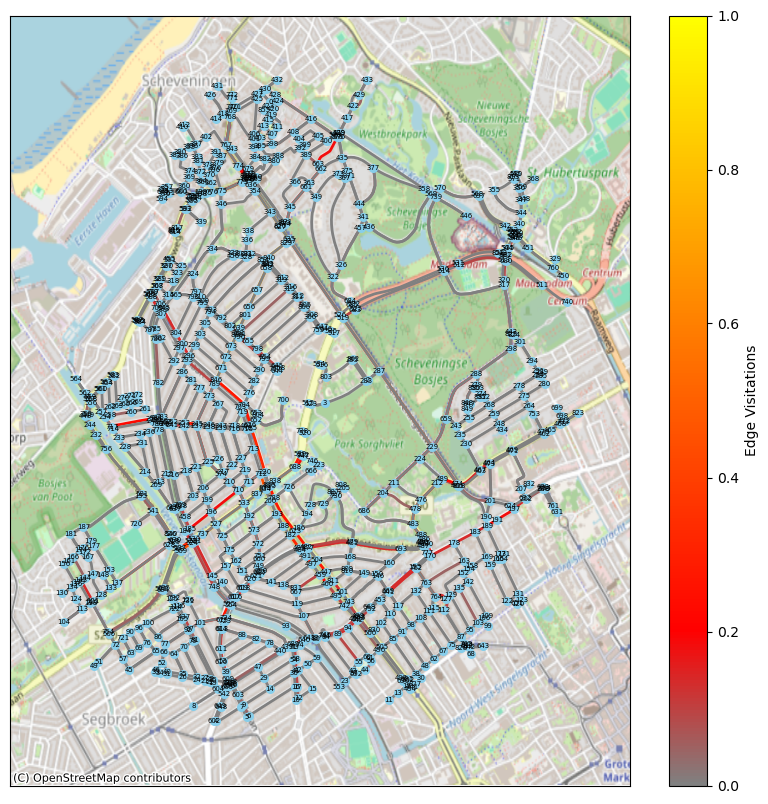


Most Visited Edges:
          Edge  Visitations              Edge Name
0  533 <-> 837     1.000000  President Kennedylaan
1  627 <-> 635     0.909091        Scheveningseweg
2  627 <-> 820     0.863636        Scheveningseweg
3  702 <-> 800     0.863636   Frederik Hendriklaan
4  656 <-> 801     0.772727     Prins Mauritsplein
5  639 <-> 702     0.772727     Prins Mauritsplein
6  671 <-> 846     0.772727   Frederik Hendriklaan
7  671 <-> 672     0.772727   Frederik Hendriklaan
8  673 <-> 800     0.772727   Frederik Hendriklaan
9  829 <-> 840     0.772727            Frankenslag


In [79]:
# Heatmap base scenario
plot_edge_heatmap_from_final_results(G6, final_results)

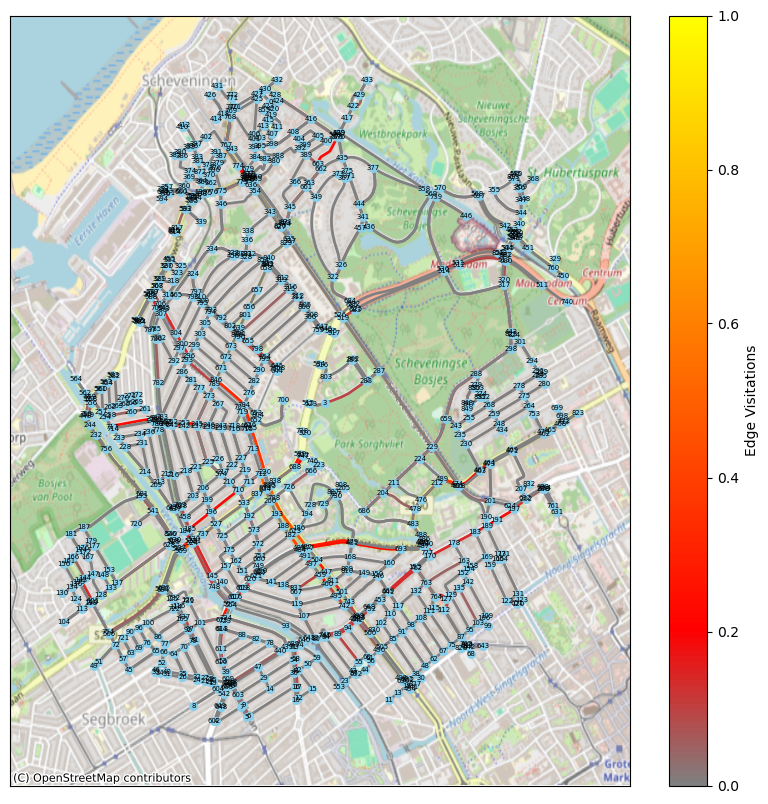


Most Visited Edges:
          Edge  Visitations              Edge Name
0  533 <-> 837     1.000000  President Kennedylaan
1  656 <-> 801     1.000000     Prins Mauritsplein
2  639 <-> 702     1.000000     Prins Mauritsplein
3  702 <-> 800     1.000000   Frederik Hendriklaan
4  829 <-> 840     1.000000            Frankenslag
5  656 <-> 657     0.954545   Frederik Hendriklaan
6  657 <-> 658     0.954545   Frederik Hendriklaan
7  671 <-> 846     0.954545   Frederik Hendriklaan
8  671 <-> 672     0.954545   Frederik Hendriklaan
9  673 <-> 800     0.954545   Frederik Hendriklaan


In [80]:
# Heatmap closed lanes scenario
plot_edge_heatmap_from_final_results(New_G, final_results2)

# Extra analysis